# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Definieer data locaties
rootdir = os.path.join(os.getcwd(), '../')
datadir = os.path.join(rootdir, 'data')

#load custom style: 
sys.path.append(rootdir)           #add this parent to the system path
from utils import plotstyle
plotstyle.initialize_custom_style()

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

##my utils: 
def date_converter(dataframe): 
    """
        function that takes a dataframe and converts the columns to pd.datetime. 
    """
    dataframe['verwachte datum'] = pd.to_datetime(dataframe['verwachte datum'],format='%m/%d/%Y')
    dataframe['birthdate'] = pd.to_datetime(dataframe['birthdate'], format = '%Y-%m-%d')
    return dataframe


def find_extremes(dataframe, how_many=8):
    """
        takes a dataframe and integer as arguments: 

        function will filter out the top x (how_many == int type) records that are outliers based on the absolute distance to the mean 
        of a given dataframe for the second half of the year. 
    """
    mean_clean = dataframe.total_births.mean()
    dataframe['distance_to_mean_abs'] = np.abs(dataframe.total_births-mean_clean)
    #we filter on the second half of the year: (365/2)      then we sort them on the absolute diatnce to the mean   and we return a slice:
    return list(dataframe[dataframe.doy_birth > int(365/2)].sort_values('distance_to_mean_abs', ascending=False).iloc[0:how_many].doy_birth)



## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [3]:
datalist = []
for file in os.listdir(datadir):
    datafile = pd.read_csv(os.path.join(datadir, file))
    date_of_birth = file.replace('.csv', '')
    datafile['birthdate'] = date_of_birth.strip()
    if file.startswith('2019-2-29'):
        df_wrong = datafile.copy()
        df_wrong['reason'] = 'date does not exist'
        continue

    datalist.append(datafile)


In [4]:
#merge everything into a single dataframe: 
data = pd.concat(datalist, ignore_index=True)

In [5]:
data.isnull().sum()     #NO NULLS, good to go

gemeente           0
naam               0
geslacht           0
verwachte datum    0
birthdate          0
dtype: int64

In [6]:
data.describe()

,gemeente,naam,geslacht,verwachte datum,birthdate
count,116850,116850,116850,116850,116850
unique,579,5255,2,427,365
top,Antwerpen,Maria,Mannelijk,07/06/2019,2019-7-1
freq,6051,1627,58932,399,923


In [7]:
data.sample(20)

,gemeente,naam,geslacht,verwachte datum,birthdate
18270,Sint-Lambrechts-Woluwe,Anna,Vrouwelijk,10/07/2019,2019-10-5
77707,Erpe-Mere,Isabelle,Vrouwelijk,06/23/2019,2019-6-11
40610,Walcourt,Laura,Vrouwelijk,02/25/2019,2019-2-17
34384,Sint-Jans-Molenbeek,Salim,Mannelijk,01/07/2020,2019-12-27
95316,Heuvelland,Thijs,Mannelijk,08/13/2019,2019-7-31
18717,Beveren (Sint-Niklaas),Jacqueline,Vrouwelijk,10/01/2019,2019-10-7
19502,Binche,Rayan,Mannelijk,10/21/2019,2019-10-9
20452,Stabroek,Paula,Vrouwelijk,11/15/2019,2019-11-12
77626,Kampenhout,Carine,Vrouwelijk,06/18/2019,2019-6-10
55439,Herve,Vincent,Mannelijk,03/08/2019,2019-3-4


In [8]:

#make life easier and let's change the two date fields into datetime objects:
#data['verwachte datum'] = pd.to_datetime(data['verwachte datum'],format='%m/%d/%Y')
#data['birthdate'] = pd.to_datetime(data['birthdate'], format = '%Y-%m-%d')

data = date_converter(data)

In [9]:
data_extended = data.copy()
#add the Day Of Year ==> DOY_ prefix used
data_extended['doy_birth'] = data_extended.birthdate.dt.dayofyear
data_extended['doy_expected'] = data_extended['verwachte datum'].dt.dayofyear
data_extended['weekday'] = data_extended.birthdate.dt.strftime('%A')

In [10]:
data_extended

,gemeente,naam,geslacht,verwachte datum,birthdate,doy_birth,doy_expected,weekday
0,Hooglede,Elias,Mannelijk,2019-01-14,2019-01-01,1,14,Tuesday
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,2019-01-05,2019-01-01,1,5,Tuesday
2,Wijnegem,Anita,Vrouwelijk,2019-01-05,2019-01-01,1,5,Tuesday
3,Grâce-Hollogne,Jean-Paul,Mannelijk,2019-01-13,2019-01-01,1,13,Tuesday
4,Boussu,François,Mannelijk,2019-01-26,2019-01-01,1,26,Tuesday
...,...,...,...,...,...,...,...,...
116845,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252,255,Monday
116846,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252,247,Monday
116847,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252,263,Monday
116848,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252,301,Monday


## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

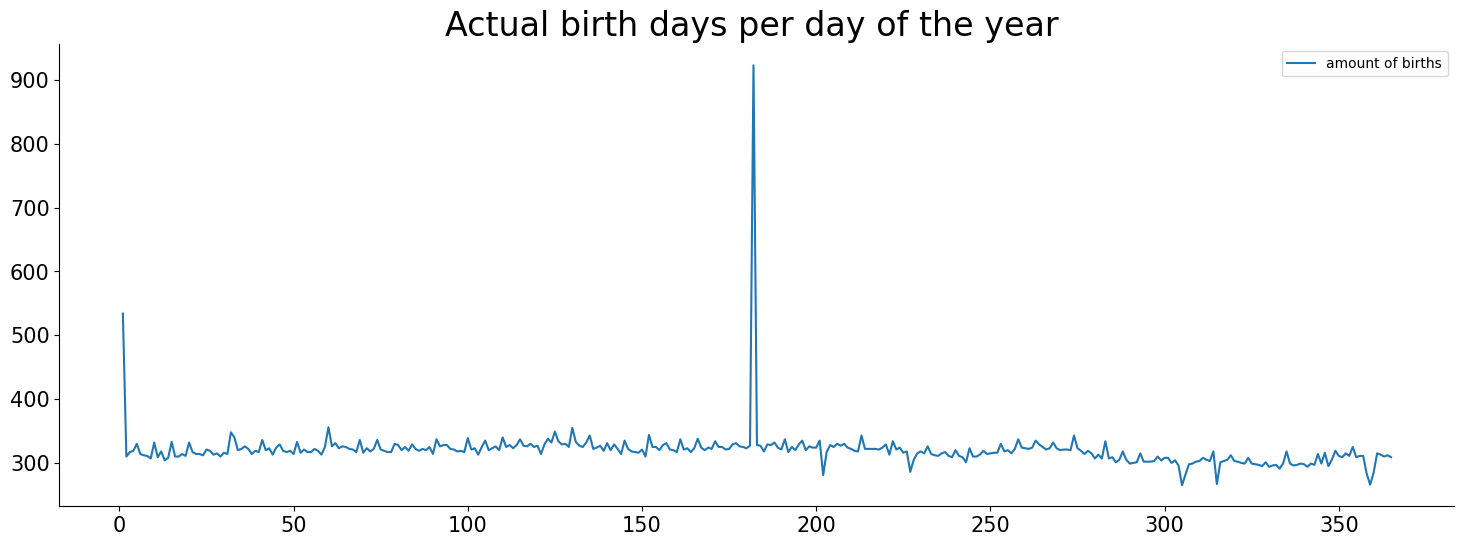

In [11]:
births_per_day = data_extended.groupby('doy_birth').size().reset_index()
births_per_day
#data_extended.query('doy_birth == 361') #random checks okay: good to go
fig, ax = plt.subplots() 
ax.plot(births_per_day.doy_birth, births_per_day[0], label='amount of births')
plt.title('Actual birth days per day of the year ')
plt.legend()
plt.show()

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [12]:
#mean actuals: 
mean_actuals = births_per_day[0].mean()
#define the boundaries; 
mean_low = mean_actuals/2   #lower boundary = half of the mean
mean_high = 1.5*mean_actuals    #upper boundary mean + half of the mean
keep_mask = births_per_day[0].between(mean_low, mean_high)
doy_birth_records_to_remove = list(births_per_day[~keep_mask].doy_birth)


doy_birth_records_to_remove       #these are the DOY_birth values we have to remove: 

[1, 182]

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [13]:
temp_transfer = data_extended[data_extended['doy_birth'].isin(doy_birth_records_to_remove)].copy()
# we will convert the birthdate back to the string as it exists in df_wrong. The reason for this is 
#that we want to retain column-uniformatie. 29/2/2019 cannot be a datetime, so our next best option
#is to keep it as a string. This way, we don't  lose data.
#We won't bother dropping the extra columns. Pandas will autofill it with NULL for us anyway. We know
#we caused it here, so not a big deal. 


temp_transfer['birthdate'] = temp_transfer['birthdate'].dt.strftime('%Y-%m-%d')

In [14]:
temp_transfer.birthdate.dtype   #okay it's an object now. 
temp_transfer['reason'] = temp_transfer.birthdate
print(df_wrong.shape)           # if we do the concat good we should be 73+1457 rows in wrong.
print(temp_transfer.shape)
#do not reassign to df_wrong, otherwise a second iter of this cell will crete duplicate
df_wrong_extended = pd.concat([df_wrong, temp_transfer], ignore_index=True)


(73, 6)
(1457, 9)


In [15]:
#now we want to remove these days from data_extended: 
mask = data_extended['doy_birth'].isin(doy_birth_records_to_remove)
data_extended_filtered = data_extended[~mask]
#check: did we do good: 
data_extended_filtered.shape[0]+temp_transfer.shape[0] == data_extended.shape[0]
#done: 
#   data that had to be removed from data_extended is moved into df_wrong_extended. 
#   df_wrong has systematic strings representing (wrong) dates (unity of type conserved)


True

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

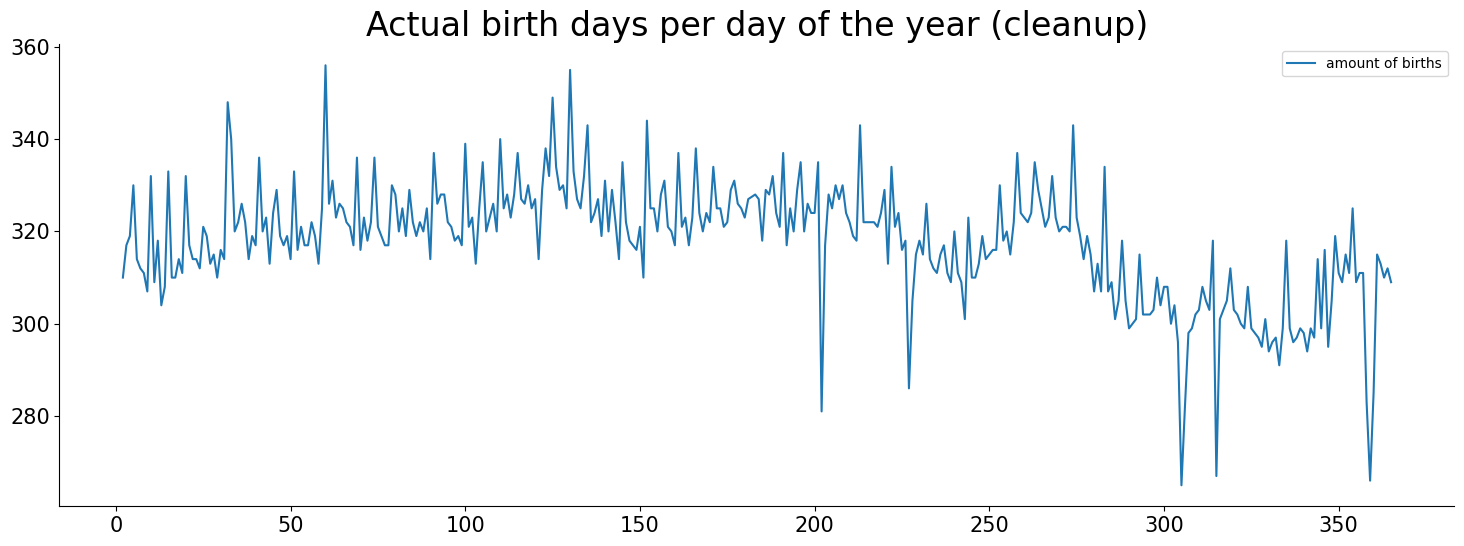

In [16]:
births_per_day_clean = data_extended_filtered.groupby('doy_birth').size().reset_index()
births_per_day_clean.columns = ['doy_birth', 'total_births']
#data_extended.query('doy_birth == 361') #random checks okay: good to go
fig, ax = plt.subplots() 
ax.plot(births_per_day_clean.doy_birth, births_per_day_clean.total_births, label='amount of births')
plt.title('Actual birth days per day of the year (cleanup)')
plt.legend()
plt.show()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [17]:
#based on the example graph provided you'd just query on everything that's lower than 290?
#I'm assuming we can't do that and need to look for extreme values. 
#what I'll do is calculate the mean, and then for each day the distance to that mean. The days with the highest distance are the outliers: 
#mean_clean = births_per_day_clean.doy_birth

#TODO DISCUSS WITH TIM: Tim is calculating extreme values based on low outliers, in fact, when you look at the absolute distance, we have high outliers too. Don't we need these.

extreme_doys = find_extremes(births_per_day_clean, 8)
print('These are the extreme days:')
combined = (births_per_day_clean[births_per_day_clean.doy_birth.isin(extreme_doys)]
            .merge(data_extended[['doy_birth','birthdate']], on='doy_birth', how='left')
            .drop_duplicates()
            )
combined

These are the extreme days:


,doy_birth,total_births,distance_to_mean_abs,birthdate
0,202,281,36.887052,2019-07-21
281,227,286,31.887052,2019-08-15
567,305,265,52.887052,2019-11-01
832,306,282,35.887052,2019-11-02
1114,315,267,50.887052,2019-11-11
1381,358,283,34.887052,2019-12-24
1664,359,266,51.887052,2019-12-25
1930,360,285,32.887052,2019-12-26


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

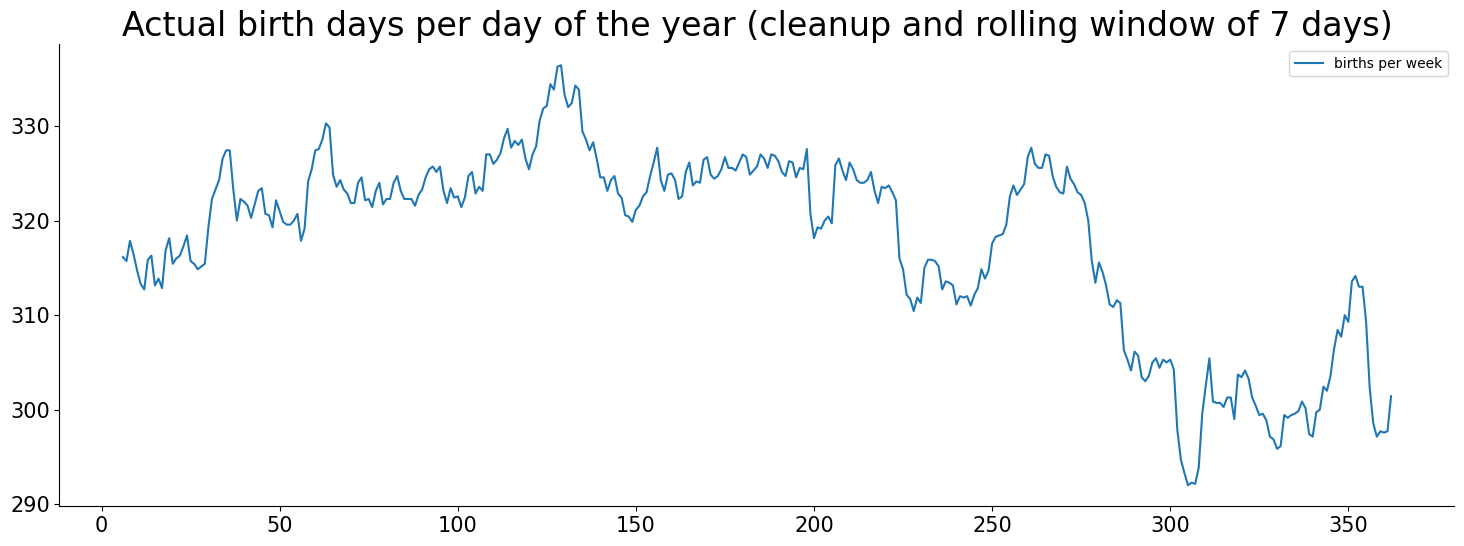

In [18]:
births_per_day_clean['moving_avg'] = births_per_day_clean['total_births'].rolling(window=7).mean()
fig, ax = plt.subplots() 
ax.plot(births_per_day_clean.index, births_per_day_clean['moving_avg'], label='births per week')
plt.title('Actual birth days per day of the year (cleanup and rolling window of 7 days)')
plt.legend()
plt.show()

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

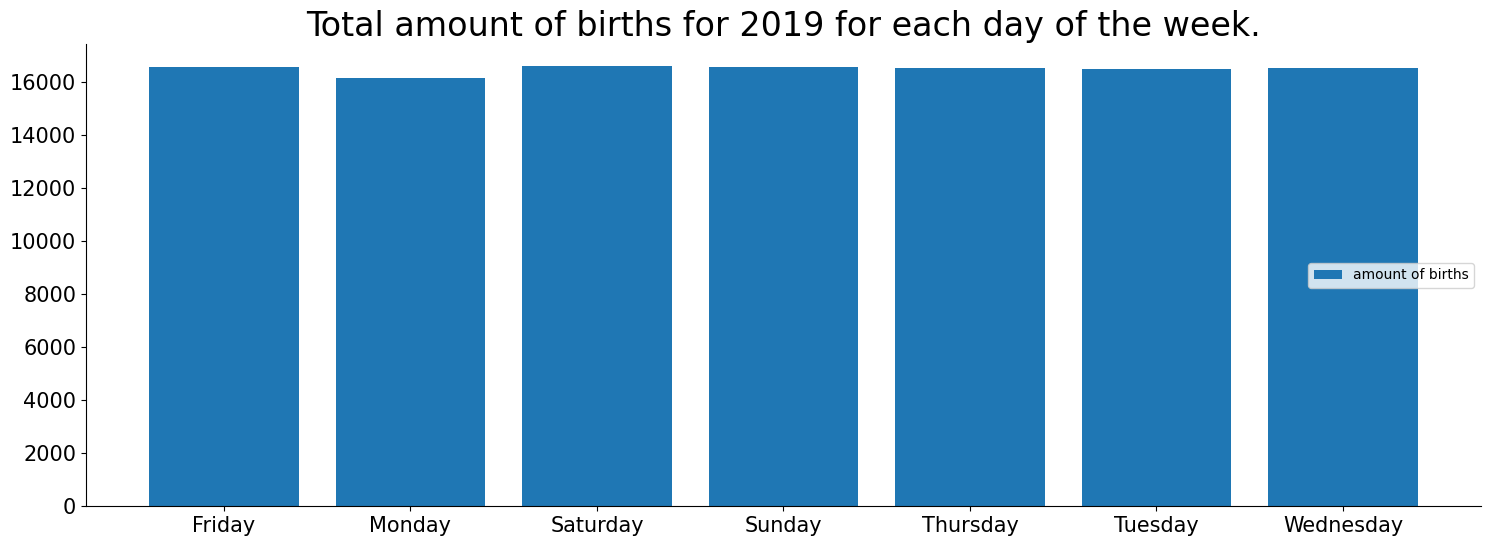

In [19]:
#we are using the data without the wrong date 29/2 and our outliers at the start and the middle of the year: 
weekcounts = data_extended_filtered.groupby('weekday').size().reset_index()
fig, ax = plt.subplots() 
ax.bar(weekcounts.weekday, weekcounts[0], label='amount of births')
plt.title('Total amount of births for 2019 for each day of the week.')
plt.legend(loc='center right')
plt.show()